In [1]:
import yfinance as yf
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings
from time import time
from sklearn.metrics import mean_squared_error
import csv
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import itertools
from scipy.stats import chi2
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
from statsmodels.api import OLS


warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
df = pd.read_csv('Data.csv')
df = pd.DataFrame(df)

# **Variables**

In [3]:
prices = {}
returns = {}
sma = {}
sd = {}
positions = {}
history = {}
rf = 0.001

# **Bollinger Bands Strategy**

In [4]:
for crypto, value in list(df.items()):
    prices[crypto] = []
    sma[crypto] = []
    sd[crypto] = []
    positions[crypto] = []

    prices[crypto] = value
    print(crypto)

    sma[crypto] = prices[crypto].rolling(window=30).mean()
    sd[crypto] = prices[crypto].rolling(window=30).std()

    POS = [False, False, False, False]
    for i in range(len(prices[crypto])):
        if prices[crypto][i] > sma[crypto][i] + 2 * sd[crypto][i] and not POS[0]:
            positions[crypto].append(-0.5)
            POS[0] = True
        elif prices[crypto][i] > sma[crypto][i] + 4 * sd[crypto][i] and not POS[1]:
            positions[crypto].append(-0.5)
            POS[1] = True
        elif prices[crypto][i] < sma[crypto][i] - 2 * sd[crypto][i] and not POS[2]:
            positions[crypto].append(0.5)
            POS[2] = True
        elif prices[crypto][i] < sma[crypto][i] - 4 * sd[crypto][i] and not POS[3]:
            positions[crypto].append(0.5)
            POS[3] = True

        elif (sma[crypto][i] - sd[crypto][i] < prices[crypto][i]) and (POS[0]):
            positions[crypto].append(-2)
            POS = [False, False, False, False]

        elif (sma[crypto][i] - sd[crypto][i] < prices[crypto][i]) and (POS[1]):
            positions[crypto].append(-2)
            POS = [False, False, False, False]

        elif (prices[crypto][i] < sma[crypto][i] + sd[crypto][i]) and (POS[2]):
            positions[crypto].append(2)
            POS = [False, False, False, False]

        elif (prices[crypto][i] < sma[crypto][i] + sd[crypto][i]) and (POS[3]):
            positions[crypto].append(2)
            POS = [False, False, False, False]

        else:
            positions[crypto].append(-1)

['USDC-USD', 'DAI-USD', 'LTC-USD', 'TUSD-USD']
['USDC-USD', 'DAI-USD', 'LEO-USD', 'TUSD-USD']
['USDC-USD', 'DAI-USD', 'XMR-USD', 'TUSD-USD']
['SOL-USD', 'USDC-USD', 'DAI-USD', 'XMR-USD']
['USDC-USD', 'SHIB-USD', 'DAI-USD', 'CRO-USD']
['USDC-USD', 'DOGE-USD', 'DAI-USD', 'XMR-USD']
['USDC-USD', 'DAI-USD', 'ATOM-USD', 'XMR-USD']
['USDC-USD', 'DAI-USD', 'XMR-USD']
['ETH-USD', 'USDC-USD', 'DAI-USD', 'CRO-USD']
['USDC-USD', 'DAI-USD', 'XMR-USD', 'HBAR-USD']


# **Backtest**

In [5]:
initial_cap = 1000
total = {}
for crypto, value in list(df.items()):
  history[crypto] = {'Position': [], 'Total': [], 'Balance': []}
  total[crypto] = 0
  for j in range(len(prices[crypto])):
      if positions[crypto][j] == 0.5:
        number_of_shares_consider_money = initial_cap / df[crypto][j]
        number_of_buy_share = number_of_shares_consider_money / 2
        total[crypto] += number_of_buy_share
        initial_cap -= number_of_buy_share * df[crypto][j]

        history[crypto]['Position'].append('BUY')
        history[crypto]['Total'].append(total[crypto])
        history[crypto]['Balance'].append(initial_cap)

      elif positions[crypto][j] == -0.5:
        number_of_shares_consider_money_s = initial_cap / df[crypto][j]
        initial_cap += number_of_shares_consider_money_s/2 * df[crypto][j]
        number_of_shares_consider_money_s /= 2
        history[crypto]['Position'].append('SELL')
        history[crypto]['Total'].append(total[crypto])
        history[crypto]['Balance'].append(initial_cap)

      elif positions[crypto][j] == -2:
        initial_cap -= (number_of_shares_consider_money_s*df[crypto][j])
        total[crypto] = 0
        history[crypto]['Position'].append('CLOSE')
        history[crypto]['Total'].append(total[crypto])
        history[crypto]['Balance'].append(initial_cap)

      elif positions[crypto][j] == 2:
        initial_cap += total[crypto] * df[crypto][j]
        total[crypto] = 0
        history[crypto]['Position'].append('CLOSE')
        history[crypto]['Total'].append(total[crypto])
        history[crypto]['Balance'].append(initial_cap)

      else:
        history[crypto]['Position'].append('EASY')
        history[crypto]['Total'].append(total[crypto])
        history[crypto]['Balance'].append(initial_cap)

  initial_cap = 1000


# **Sharpe Ratio Function**

In [6]:
def sharpe_ratio_func(history):
  excess_returns = pd.DataFrame(history['Balance']).pct_change().dropna()
  annualized_std = excess_returns.std() * np.sqrt(365)
  sharpe_ratio = (excess_returns.mean() - rf) / annualized_std
  return sharpe_ratio[0]

In [7]:
for crypto, value in list(df.items()):
  print(f"{crypto} Sharpe Ratio:", sharpe_ratio_func(history[crypto]))

['USDC-USD', 'DAI-USD', 'LTC-USD', 'TUSD-USD'] Sharpe Ratio: 0.0035996257683347144
['USDC-USD', 'DAI-USD', 'LEO-USD', 'TUSD-USD'] Sharpe Ratio: 0.003441328592474485
['USDC-USD', 'DAI-USD', 'XMR-USD', 'TUSD-USD'] Sharpe Ratio: 0.0036508645752641538
['SOL-USD', 'USDC-USD', 'DAI-USD', 'XMR-USD'] Sharpe Ratio: 0.0036337236335360606
['USDC-USD', 'SHIB-USD', 'DAI-USD', 'CRO-USD'] Sharpe Ratio: 0.0030291117254165616
['USDC-USD', 'DOGE-USD', 'DAI-USD', 'XMR-USD'] Sharpe Ratio: 0.0035561358409922465
['USDC-USD', 'DAI-USD', 'ATOM-USD', 'XMR-USD'] Sharpe Ratio: 0.0035551077098601317
['USDC-USD', 'DAI-USD', 'XMR-USD'] Sharpe Ratio: 0.003554370834378109
['ETH-USD', 'USDC-USD', 'DAI-USD', 'CRO-USD'] Sharpe Ratio: 0.0037341999293072884
['USDC-USD', 'DAI-USD', 'XMR-USD', 'HBAR-USD'] Sharpe Ratio: 0.0035531421940316467


# **Equity Function**

In [8]:
def calculate_equity(backtest, initial_cap):
    equity = [initial_cap]
    for i in range(1, len(backtest)):
        equity.append(backtest['Balance'].iloc[i])
    return equity

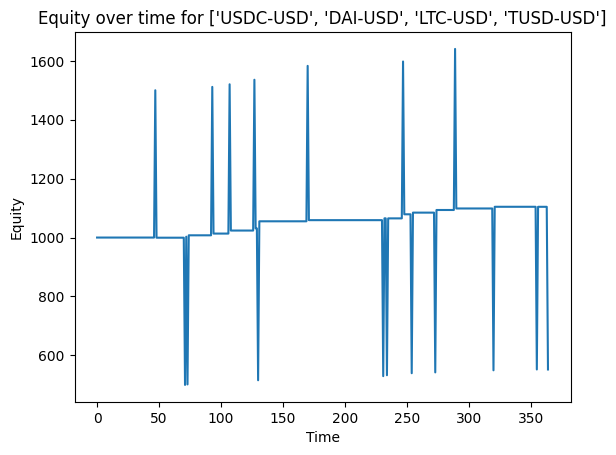

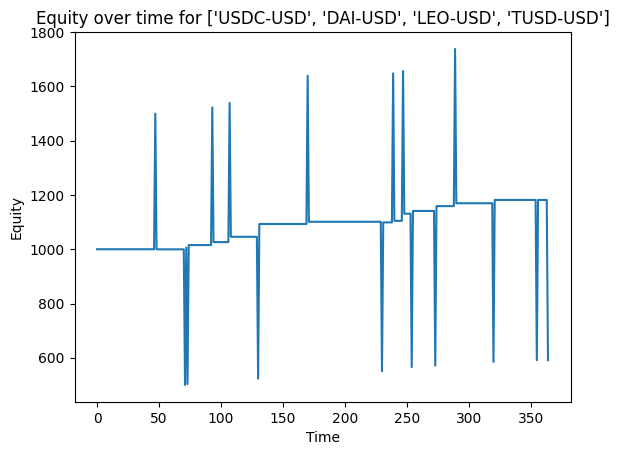

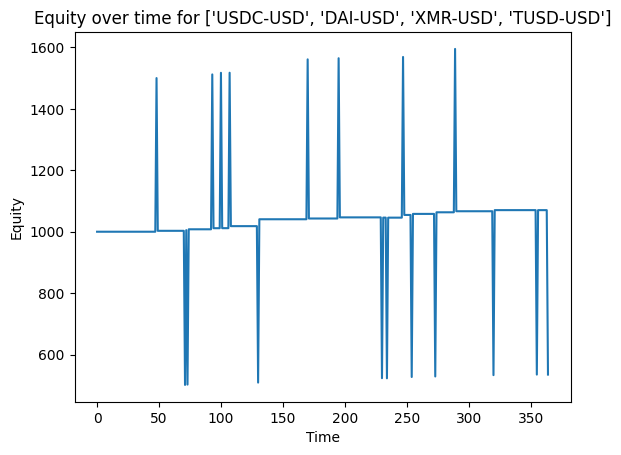

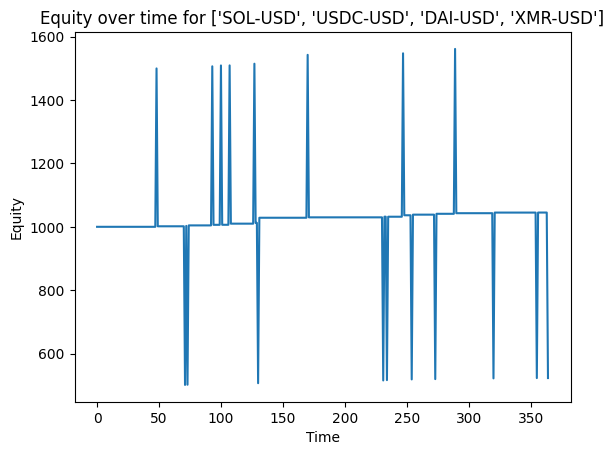

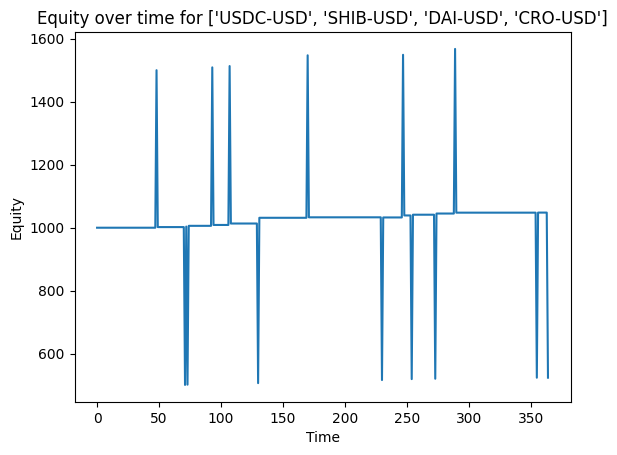

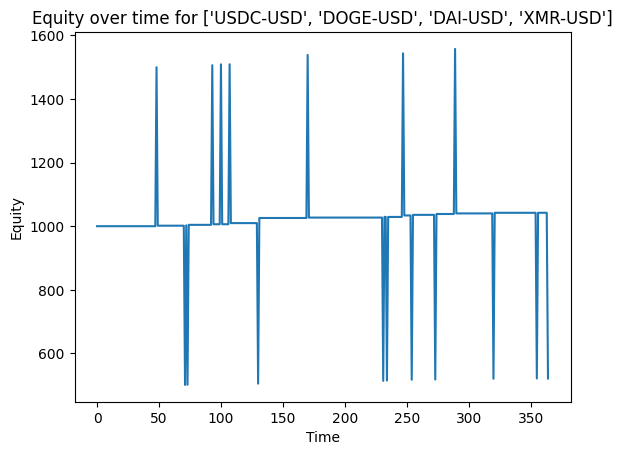

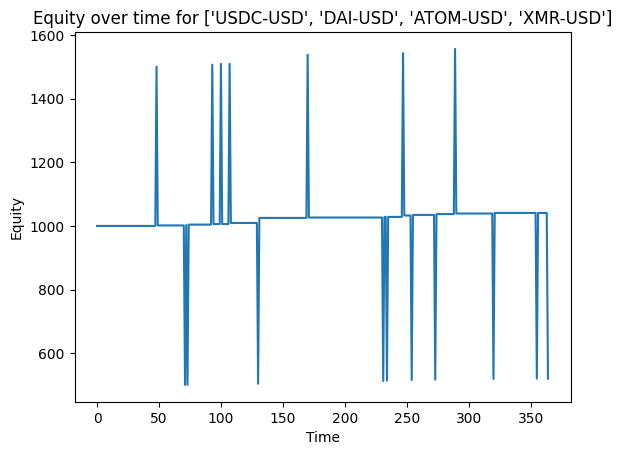

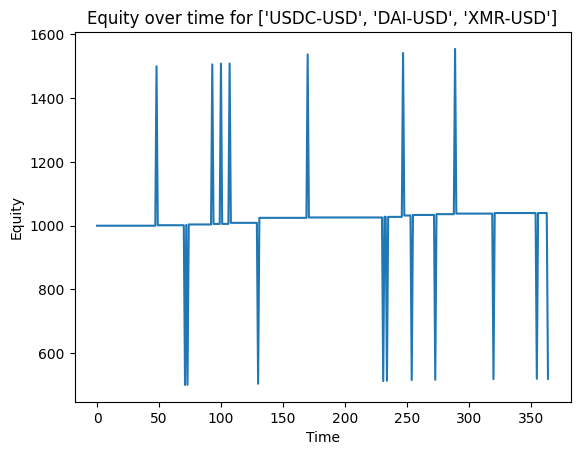

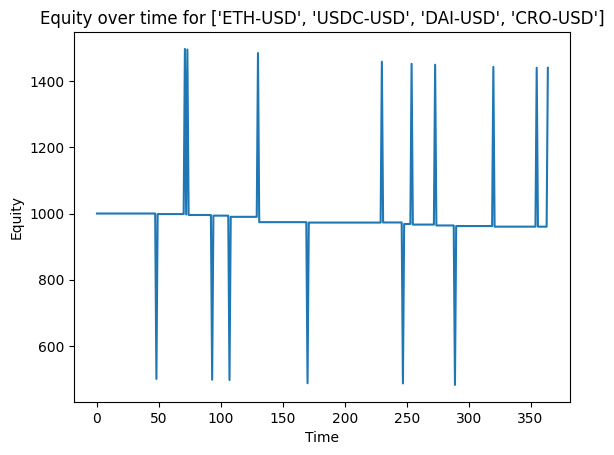

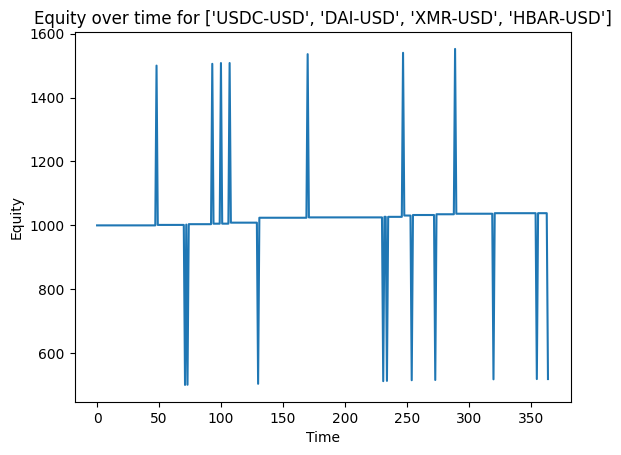

In [9]:
for crypto, value in list(df.items()):
  equity = calculate_equity(pd.DataFrame(history[crypto]), 1000)
  plt.figure()
  plt.plot(equity)
  plt.xlabel('Time')
  plt.ylabel('Equity')
  plt.title(f'Equity over time for {crypto}')
  plt.show()